# MNIST Classification using Predictive Coding

This notebook implements a Predictive Coding Network (PCN) for MNIST digit classification.

## Setup and Imports
The following cell sets up our environment with necessary PyTorch imports and checks for GPU availability.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# to display matplotlib plots inline (directly below the cell)
%matplotlib inline


Using device: cpu


## Data Loading and Preprocessing

Here we:
1. Define data transformations (convert to tensor and normalize)
2. Load the MNIST dataset for training and testing
3. Create data loaders
4. Print dataset statistics

The MNIST dataset contains 60,000 training images and 10,000 test images of handwritten digits (0-9).


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),                   
    transforms.Normalize((0.1307,), (0.3081,))  
])

# get the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform
)

# create data loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size:     {len(test_dataset)}")
print(f"Number of batches in training: {len(train_loader)}")
print(f"Number of batches in testing:  {len(test_loader)}")


Training dataset size: 60000
Test dataset size:     10000
Number of batches in training: 938
Number of batches in testing:  157


### visualize a batch of training images to understand our input data, vertify the data loaded correctly and see examples. 



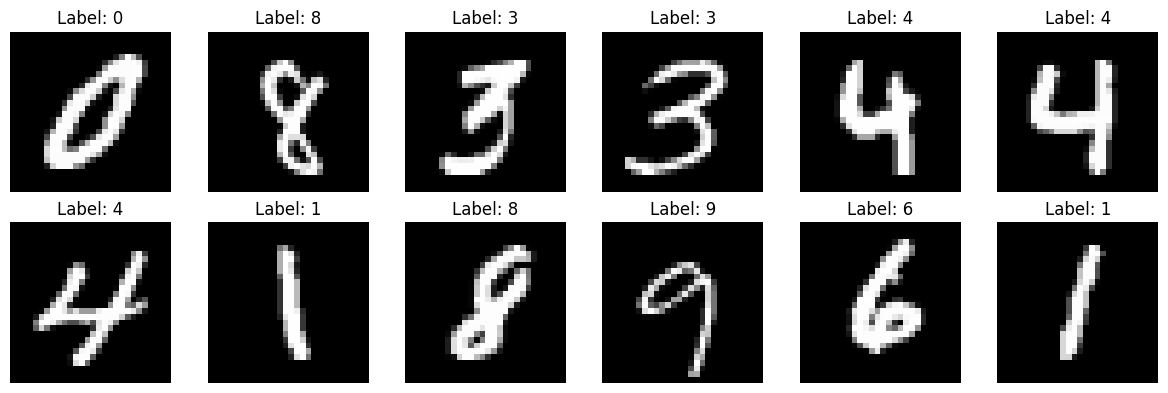

In [4]:
# get a batch of training data
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i + 1)
    # remove normalization
    img = images[i].squeeze()
    img = img * 0.3081 + 0.1307
    ax.imshow(img, cmap='gray')
    ax.set_title(f'Label: {labels[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()


## Predictive Coding Architecture

We define a simple architecture for our Predictive Coding Network:
- Input layer: 784 units (28x28 flattened images)
- Hidden layer 1: 256 units with ReLU activation
- Hidden layer 2: 128 units with ReLU activation
- Hidden layer 3: 64 units with ReLU activation
- Output layer: 10 units (one per digit)


In [5]:
class PCMNISTNet(nn.Module):
    def __init__(self):
        super(PCMNISTNet, self).__init__()
        self.W1 = nn.Linear(28*28, 256, bias=False)
        self.W2 = nn.Linear(256, 128, bias=False)
        self.W3 = nn.Linear(128, 64, bias=False)
        self.W4 = nn.Linear(64, 10, bias=False)
        # lateral connections for hidden layers 2 and 3
        self.L2 = nn.Linear(128, 128, bias=False)
        self.L3 = nn.Linear(64, 64, bias=False)
        for layer in [self.L2, self.L3]:
            nn.init.normal_(layer.weight, mean=0.0, std=0.01)
            mask = ~torch.eye(layer.weight.shape[0], dtype=torch.bool)
            layer.weight.data *= mask
        self.act = torch.relu

    def predict(self, x, lateral_strength=0.1):
        # forward pass to initialize latent states
        z0 = x.view(x.size(0), -1)
        z1 = self.act(self.W1(z0))
        z2_ff = self.act(self.W2(z1))
        lat2 = self.act(self.L2(z2_ff))
        z2 = z2_ff + lateral_strength * lat2
        z3_ff = self.act(self.W3(z2))
        lat3 = self.act(self.L3(z3_ff))
        z3 = z3_ff + lateral_strength * lat3
        z4 = self.W4(z3) # we want raw outputs here so no activation
        return [z0, z1, z2, z3, z4]

# Instantiate model
model = PCMNISTNet().to(device)
print(model)

PCMNISTNet(
  (W1): Linear(in_features=784, out_features=256, bias=False)
  (W2): Linear(in_features=256, out_features=128, bias=False)
  (W3): Linear(in_features=128, out_features=64, bias=False)
  (W4): Linear(in_features=64, out_features=10, bias=False)
  (L2): Linear(in_features=128, out_features=128, bias=False)
  (L3): Linear(in_features=64, out_features=64, bias=False)
)
